# TP OpenMP - October 2022
## Part 1 : Pi
### Compilation

In [23]:
!nvcc -o tp_cuda_part_1_1_pi part1/tp_cuda_part_1_1_pi.cu -O3
!nvcc -o tp_cuda_part_1_3_pi part1/tp_cuda_part_1_3_pi.cu -O3
!nvcc -o tp_cuda_part_1_4_pi part1/tp_cuda_part_1_4_pi.cu -O3

### Performance evaluation

In [24]:
import os
import subprocess
import pandas as pd

try:
    os.remove("stats_part1.csv")
except OSError:
    pass

df = pd.DataFrame(columns=['version','nthread_per_block','nstep_per_thread','num_steps','runtime'])
df.to_csv("stats_part1.csv", index=False)

num_steps = [100, 10000, 100000]
# num_steps = [10000, 1000000, 10000000, 100000000]
nb_threads_per_block = [1, 32, 64, 128, 256]
nb_steps_per_threads = [1, 64, 256, 1024]
repeats = range(0,10)

for nsteps in num_steps:
    for nthread_per_block in nb_threads_per_block:
        for nstep_per_thread in nb_steps_per_threads:
            for repeat in repeats:
                args = ("./tp_cuda_part_1_1_pi", "-N", str(nsteps),"-tpb", str(nthread_per_block), "-spt", str(nstep_per_thread))
                popen = subprocess.Popen(args, stdout=subprocess.PIPE)
                popen.wait()

                args = ("./tp_cuda_part_1_3_pi", "-N", str(nsteps),"-tpb", str(nthread_per_block), "-spt", str(nstep_per_thread))
                popen = subprocess.Popen(args, stdout=subprocess.PIPE)
                popen.wait()

                args = ("./tp_cuda_part_1_4_pi", "-N", str(nsteps),"-tpb", str(nthread_per_block), "-spt", str(nstep_per_thread))
                popen = subprocess.Popen(args, stdout=subprocess.PIPE)
                popen.wait()



### Performance analysis

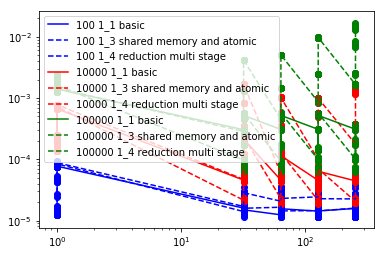

In [26]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import genfromtxt

import pandas as pd

import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('stats_part1.csv',header=0,names=['version','nthread_per_block','nstep_per_thread','num_steps','runtime'],dtype={
                     'version': str,
                     'nthread_per_block': int,
                     'nstep_per_thread': int,
                     'num_steps' : int,
                     'runtime' : float
                 })

color_num_steps = {100 : "blue", 10000 : "red", 100000 : "green", 1000000000000 : "black"}
for num_steps in df['num_steps'].drop_duplicates():
    df_plot = df[(df['num_steps'] == int(num_steps))]
    df_plot = df_plot[df_plot['version'] == "1_1 basic"]
    mean_stats = df_plot.groupby(['num_steps','version','nthread_per_block','nstep_per_thread']).mean().reset_index()
    plt.plot(mean_stats['nthread_per_block'], mean_stats['runtime'],linestyle="solid",color=color_num_steps[num_steps],label=f"{num_steps} 1_1 basic")
    plt.yscale('log')
    plt.xscale('log')
    plt.scatter(df_plot['nthread_per_block'], df_plot['runtime'],color=color_num_steps[num_steps],label=None)

    df_plot = df[(df['num_steps'] == num_steps) & (df['version'] == "1_3 shared memory and atomic")]    
    mean_stats = df_plot.groupby(['num_steps','version','nthread_per_block','nstep_per_thread']).mean().reset_index()    
    plt.plot(mean_stats['nthread_per_block'], mean_stats['runtime'],linestyle="dashed",color=color_num_steps[num_steps],label=f"{num_steps} 1_3 shared memory and atomic")
    plt.yscale('log')
    plt.xscale('log')
    plt.scatter(df_plot['nthread_per_block'], df_plot['runtime'],color=color_num_steps[num_steps],label=None)
    
    df_plot = df[(df['num_steps'] == num_steps) & (df['version'] == "1_4 reduction multi stage")]
    mean_stats = df_plot.groupby(['num_steps','version','nthread_per_block','nstep_per_thread']).mean().reset_index()
    plt.plot(mean_stats['nthread_per_block'], mean_stats['runtime'],linestyle="dashed",color=color_num_steps[num_steps],label=f"{num_steps} 1_4 reduction multi stage")
    plt.yscale('log')
    plt.xscale('log')
    plt.scatter(df_plot['nthread_per_block'], df_plot['runtime'],color=color_num_steps[num_steps],label=None)

    
plt.xlabel('nb_thread_per_block')
plt.ylabel('runtime')
plt.legend(loc='lower right', bbox_to_anchor=(-0.2, 0))
plt.show()


### Discussion